In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
from constants import NWABounds
import constants
import calculation_functions
import warnings
import matplotlib as mpl
warnings.filterwarnings('ignore')
import matplotlib.gridspec as gridspec

In [2]:
import sys
from importlib import reload
sys.path.append('')
import load_dataset as load
import phase_calc_functions as phase_calc
import map_trend_functions
import miscellaneous
import plotting_functions as pf

In [3]:
constants.IMAGE_SAVE_DIR

'/g/data/w40/ab2313/images/mjo_and_rainfall_trend_images'

In [4]:
import matplotlib
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

import matplotlib.pylab as pylab

params = {'axes.labelsize' : 16,
         'legend.fontsize': 'x-large',
          'axes.titlesize': 'xx-large',
         }

pylab.rcParams.update(params)

In [5]:
image_dir = '/g/data/w40/ab2313/images/mjo_and_rainfall_trend_images/'

# Data

In [6]:
# Loading awap
awap = load.load_awap()
awap_ws = phase_calc.wet_season_year(awap)

# Loading RMM
rmm = load.load_rmm()
rmm_ws = phase_calc.wet_season_year(rmm)

awap_ws, rmm_ws = calculation_functions.match_dataset_time(awap_ws, rmm_ws)

awap_ws = miscellaneous.apply_masks(awap_ws)

New datasets are now of lenght d1 = 5578 and d2 = 5578


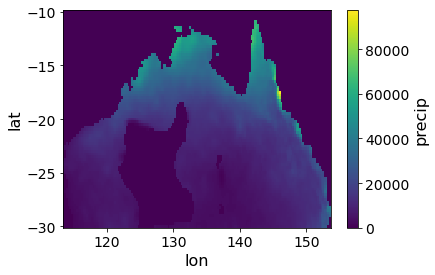

In [7]:
awap_ws.sum(dim = 'time').precip.plot()

# Phase Splitting and Wet Season Calibration

Splitting into different MJO phases (1-8) and then moving the data from Jan-March back one year. The moving of the data back one year means that all of the data for an individual wet season is now with in the one year. This makes resampling much easier.

In [8]:
# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

In [9]:
rmm_count = phase_calc.count_in_rmm_phase(rmm_ws)
rmm_count = calculation_functions.convert_time_to_year(rmm_count)
rmm_count_sub = phase_calc.resample_phase_to_subphase(rmm_count)
rmm_count_sub

Enhanced phase definition being used [5, 6]


<xarray.Dataset>
Dimensions:  (phase: 4, year: 46)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2016 2017 2018 2019 2020
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    number   (phase, year) int64 12 25 22 9 12 19 11 19 ... 43 29 18 56 15 23 46

# Bootstrap Calculation

In [10]:
def trend_line(y, use = [0][0]):
    '''
    Parameters
    ----------
    x: the y values of our trend
    use: 
    [0][0] will just return the gradient
    [0,1] will return the gradient and y-intercept.
    Previosly: _grid_trend
    '''
#     if ~isinstance(y, np.ndarray) or ~isinstance(y, list):
#         return np.nan

    if all(~np.isfinite(y)):
        return np.nan


    # Getting the gradient of a linear interpolation
    x = np.arange(len(y))
    idx = np.isfinite(y) #checking where the nans.
    x = x[idx]
    y = y[idx]

    if len(x) < 3:
        return np.nan

    poly = np.polyfit(x,y,1)

    return poly[use].round(2)

In [11]:
def nancount_nonzero(array, axis):
    '''
    Counts all the non-zero and non-nan values in an array. Like the .count function for 
    xarray. Like count_nonzero for numpy but replaces nans with 0 first.
    '''
    return np.count_nonzero(np.where(np.isfinite(np.array(array)), array, 0), axis=axis)

In [12]:
def generate_bootstrapped_data(awap_ws_array: np.ndarray, awap_time:np.ndarray, 
                               func1d, number_bootstrapping:int=10, verbose:bool=False):
    '''
    awap_ws_array: numpy.ndarray
        Array of data converted from xarray to numpy array. Time has to be on axis 0.
    awap_time: numpy.ndarray
        Array of all the time values
    func1d: func1d
        Function that is applied for the trend. In this instnace should be either of np.nansum
        or nancount_nonzero.
    number_bootstrapping: int
        The number of itterations the bootstrapping should go through
    
    '''
    # Creating an empty array to store the output of each butstrap
    boostrap_itterations = []#np.empty(number_bootstrapping, dtype=np.ndarray)
    
    unique_years = np.unique(awap_time.year)
    total_number_time_points = len(awap_time)
    
    successful_bootstraps = 0
    for num_bootstrap in range(number_bootstrapping):
        print(f'{num_bootstrap}, ', end='')
        # This is a list of empty lists. The data for each monsoon will be stored 
        # in one of the contained empty lists. They will be stored in teh list based upon 
        # which monsoon. E.g. 2020 will be in the last list.
        random_monsoon_list = [[] for i in range(len(unique_years))]

        # Create array of random data. 
        for random_number in np.random.randint(0,total_number_time_points, total_number_time_points):
            corrsepoding_time = awap_time[random_number]
            if corrsepoding_time in enhanced_phase_times:
                single_time_array = awap_ws_array[random_number]
                corrsepoding_time = awap_time[random_number]
                time_arg = int(np.argwhere(corrsepoding_time.year == unique_years))
                random_monsoon_list[time_arg].append(single_time_array)

        # Sum or count the data
        monsoon_list = []
        for single_bootstrap in random_monsoon_list:
            monsoon_yearly_stat = func1d(np.array(single_bootstrap), axis=0)
            monsoon_list.append(monsoon_yearly_stat)
   
        # For some reason, for certain monsoon lists, a single array is not passed in,
        # but rather and array of arrays. Happens very infrequently, and is hard to 
        # debug, but better to ignore.
        try:
            successful_bootstraps+=1
            # Get the trend along the axis
            grad_trend = np.apply_along_axis(trend_line, 0, monsoon_list)
            # Get the sign of the trend
            sign_grad_trend = np.where(np.sign(grad_trend) > 0, 1, 0)

            # Store the sign of the trend.
            boostrap_itterations.append(sign_grad_trend) # [num_bootstrap] =
        except TypeError as e:
            successful_bootstraps-=1
            print('Array error occured. Breaking loop')
        
    number_positive_trends = np.sum(np.array(boostrap_itterations), axis=0)
    
    print(f'Function completed {successful_bootstraps=}')
    percent_trends_positive = number_positive_trends * 100 /successful_bootstraps
    
    if verbose:
        return boostrap_itterations, number_positive_trends, percent_trends_positive
        
    return percent_trends_positive

In [13]:
enhanced_phase_times = (rmm_ws
                        .where(rmm.amplitude > 1, drop=True)
                        .where(rmm.phase.isin([4,5,6]), drop=True)
                        .time.values
                       )
enhanced_phase_times

array(['1975-01-08T00:00:00.000000000', '1975-01-09T00:00:00.000000000',
       '1975-01-10T00:00:00.000000000', ...,
       '2020-12-19T00:00:00.000000000', '2020-12-20T00:00:00.000000000',
       '2020-12-21T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
awap_ws_array = awap_ws.precip.values
awap_ws_array.shape

(5578, 80, 161)

In [15]:
awap_time = pd.to_datetime(awap_ws.time.values)
awap_time.shape

(5578,)

In [16]:
np.unique(awap_time.year)

array([1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [17]:
total_number_time_points = len(awap_time)
total_number_time_points

5578

In [18]:
number_bootstrapping = 1000

In [19]:
%%time
percent_trends_positive_sum  = generate_bootstrapped_data(awap_ws_array, awap_time, np.nansum,
                                                       number_bootstrapping=number_bootstrapping)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [22]:
boostrap_itterations_count, number_positive_trends_count, percent_trends_positive_count=\
        generate_bootstrapped_data(awap_ws_array, awap_time, nancount_nonzero,
                                   number_bootstrapping=number_bootstrapping, verbose=True)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, Array error occured. Breaking loop
201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

In [23]:
# %%time
# percent_trends_positive_count = generate_bootstrapped_data(awap_ws_array, awap_time, nancount_nonzero,
#                                                        number_bootstrapping=1000)

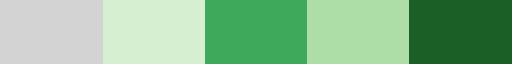

In [24]:
color_array = ['lightgrey', '#D6EFD1', '#3EA95B', '#ADDEA7', '#1B5F27']
bootstrap_cmap = mpl.colors.ListedColormap(color_array)
bootstrap_cmap

In [25]:
levels = (0, 90, 95, 99, 100)
norm = mpl.colors.BoundaryNorm(levels, bootstrap_cmap.N)

In [26]:
base_ds = awap_ws.isel(time=0).drop('time').rename({'precip': 'percent'})
                                                   
boostrap_sum_ds = xr.zeros_like(base_ds) + percent_trends_positive_sum
boostrap_count_ds = xr.zeros_like(base_ds) + percent_trends_positive_count

boostrap_sum_ds

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 161)
Coordinates:
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 113.5 113.8 114.0 114.2 ... 152.8 153.0 153.2 153.5
Data variables:
    percent  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    History:      AGCD Regrid on the 11th of June 2021 from /g/data/rr5 by ab...

max_value=100
levels=(0, 90, 95, 99, 100)
max_value=100
levels=(0, 90, 95, 99, 100)


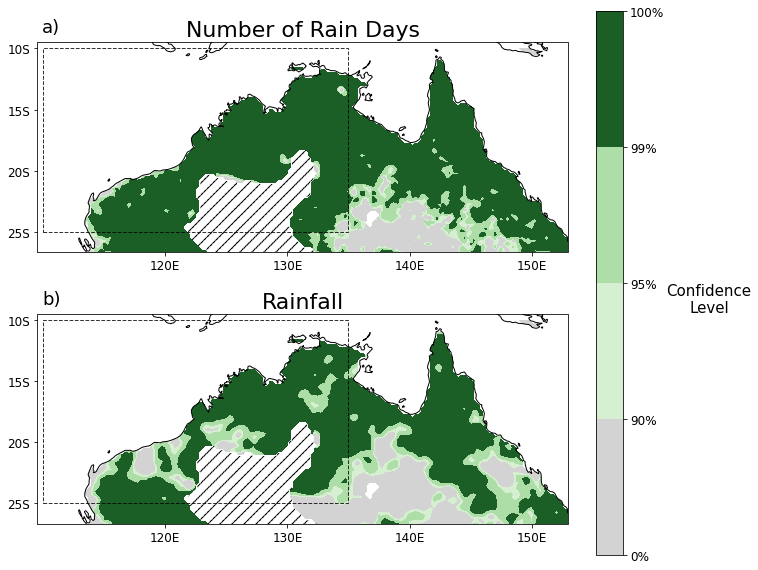

In [28]:
fig, gs = pf.fig_formatter(height_ratios = [1,1], width_ratios = [1, 0.05], hspace = 0.0, wspace = 0.1)

ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
c = pf.nwa_map_plot(boostrap_count_ds.percent, ax1, cmap=bootstrap_cmap, levels=levels, #norm=norm,
                   title='Number of Rain Days', debug=True)
pf.add_figure_label(ax1, 'a)')

ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
c = pf.nwa_map_plot(boostrap_sum_ds.percent, ax2, cmap=bootstrap_cmap, levels=levels,
                    title='Rainfall', debug=True)
pf.add_figure_label(ax2, 'b)')


cax = plt.subplot(gs[:,1])
ticks = [str(l) + '%' for l in levels]
pf.create_colorbar(c, cax, levels,  ticks=ticks, cbar_title =  "Confidence\nLevel",
                   orientation = 'vertical', rotation = 0,  labelpad=45)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR, '05_boostrapping_awap_count_sum.png'),
            bbox_inches='tight', dpi=500)